### Importing the dependencies

In [59]:
# For data visualization and manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import re
import pickle

# For data processing
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OrdinalEncoder,PowerTransformer,MinMaxScaler,StandardScaler)
from sklearn.model_selection import train_test_split
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

print("Everything imported successfully😊")

Everything imported successfully😊


### Dataset desciption
- VoLTE stands for Voice over LTE. It is a technology that allows you to make and receive calls over the LTE network. This means that you can enjoy better call quality and voice clarity, even when you are in a poor cellular reception area.- 
Wi-Fi is a wireless networking technology that allows you to connect to the internet without using a cellular network. This is a great way to save on your data plan, especially if you are using a lot of data for streaming videos or music
  .- 
IR Blaster is a small infrared transmitter that is built into some smartphones. It allows you to use your phone as a remote control for other devices, such as your TV, air conditioner, or stere
- NFC stands for Near Field Communication. It is a short-range wireless technology that allows two devices to communicate with each other when they are brought within close proximity. The maximum distance for NFC communication is about 4 inches.o.

In [2]:
# Loading the data from csv file to dataframe
df = pd.read_csv('Data.csv')

### Exploratory data analysis

In [3]:
# Checking shape of the dataframe
print("Shape of the dataframe : ",df.shape)

Shape of the dataframe :  (1020, 11)


In [4]:
# Checking any 3 random rows of the dataframe
df.sample(3)

,model,price,rating,sim,processor,ram,battery,display,camera,card,os
445,Asus ROG Phone 6 Batman Edition,"₹72,999",88.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 9000 Plus, Octa Core, 3.2 GHz Processor","16 GB RAM, 256 GB inbuilt",6000 mAh Battery with 65W Fast Charging,"6.78 inches, 1080 x 2448 px, 165 Hz Display",50 MP + 13 MP + 5 MP Triple Rear & 12 MP Front...,Memory Card Not Supported,Android v12
507,Xiaomi Redmi A1 Plus,"₹7,289",60.0,"Dual Sim, 3G, 4G, VoLTE, Wi-Fi","Helio A22, Quad Core, 2 GHz Processor","2 GB RAM, 32 GB inbuilt",5000 mAh Battery with 10W Fast Charging,"6.52 inches, 720 x 1600 px Display with Water ...",8 MP + 0.3 MP Dual Rear & 5 MP Front Camera,"Memory Card Supported, upto 512 GB",Android v12
99,Vivo T1 5G,"₹15,990",78.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 695, Octa Core, 2.2 GHz Processor","4 GB RAM, 128 GB inbuilt",5000 mAh Battery with 18W Fast Charging,"6.58 inches, 1080 x 2408 px, 120 Hz Display wi...",50 MP + 2 MP + 2 MP Triple Rear & 16 MP Front ...,"Memory Card (Hybrid), upto 1 TB",Android v12


In [5]:
# Let's take a look at the informatoin related to columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   model      1020 non-null   object 
 1   price      1020 non-null   object 
 2   rating     879 non-null    float64
 3   sim        1020 non-null   object 
 4   processor  1020 non-null   object 
 5   ram        1020 non-null   object 
 6   battery    1020 non-null   object 
 7   display    1020 non-null   object 
 8   camera     1019 non-null   object 
 9   card       1013 non-null   object 
 10  os         1003 non-null   object 
dtypes: float64(1), object(10)
memory usage: 87.8+ KB


model         0.000000
price         0.000000
rating       13.823529
sim           0.000000
processor     0.000000
ram           0.000000
battery       0.000000
display       0.000000
camera        0.098039
card          0.686275
os            1.666667
dtype: float64


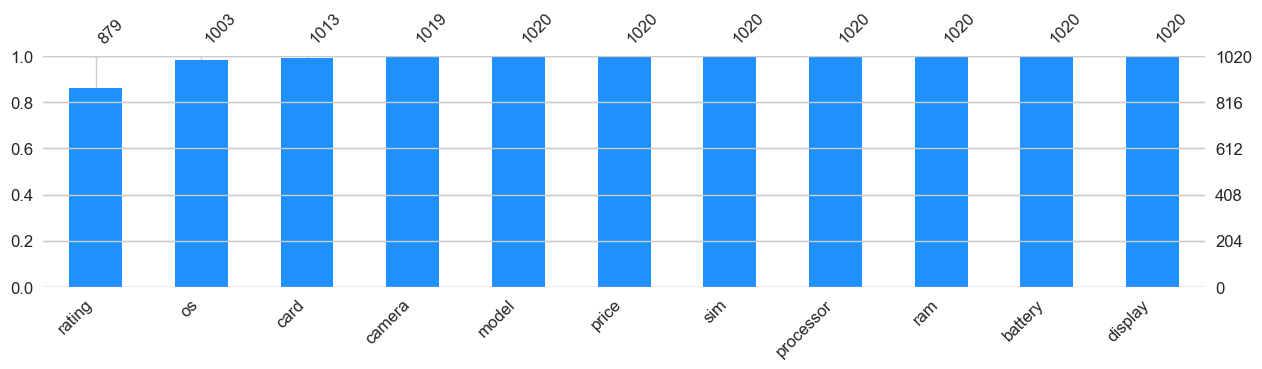

In [6]:
# Checking any missing values
print(df.isnull().mean()*100)

# Visualize missing values using a bar chart
msno.bar(df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

In [7]:
# Let's check if there are any duplicate valeus
print("Duplicate values :",df.duplicated().sum())

Duplicate values : 0


# Feature engineering and Data Processing

- `price`: Remove rupee and , character
- `sim`: Extracting a binary feature (called sim type 0 : Single sim and 1 : Dual sim)
- `sim`: Extracting a binary feature called (Has_5g)

In [8]:
# Dropping the os
df.drop(['os'],axis=1,inplace=True)

In [9]:
# Removing rupee and , character from the 'price' feature and converting to int
for index in range(len(df)):
    item = df.loc[index, 'price']
    item = item.replace("₹", "").replace(",", "")
    item = re.sub(r'[^\d]', '', item)  # Remove any non-digit characters
    df.loc[index, 'price'] = item

df['price'] = df['price'].astype(np.int64)

In [10]:
# Creating categorical values for the rating feature
for i in range(len(df)):
    item = df.loc[i,'rating']
    if item > 80.0:
        df.loc[i,'rating'] = '8+'
    elif item > 70.0:
        df.loc[i,'rating'] = '7+'
    elif item > 60.0:
        df.loc[i,'rating'] = '6+'

- Since NFC and IR blaster are some additional features in smartphones so let's create a binary feature where 1 will represent that this phone as one of additional feature and 0 if the smartphone doesn't have any.
- In our dataset there are few smartphones which don't even have Wifi and VoLTE so we also need to keep these phones into consideration so let's create a binary features for this. 1 : Has_Wifi_Volte and and 0 if not.
  


- 
The "G" in 3G, 4G, and 5G stands for "generation". These terms refer to the different generations of cellular network technolog.It is not necessary for a smartphone to have a "G" in order to be functional.y

In [11]:
str = 'Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC, IR Blaster'
print(str.split())

['Dual', 'Sim,', '3G,', '4G,', '5G,', 'VoLTE,', 'Wi-Fi,', 'NFC,', 'IR', 'Blaster']


In [12]:
# Empty lists to store data
Has_5g = []
Add_Features = []

for item in df['sim']:
    Has_5g.append(1 if '5G,' in item.split() else 0)
    Add_Features.append(1 if 'NFC,' in item.split() or 'IR,' in item.split(',') else 0)


# Convert lists to pandas Series
df['Has_5g'] = pd.Series(Has_5g)
df['Add_Features'] = pd.Series(Add_Features)
df.drop(['sim'],axis =1,inplace=True)

In [13]:
str = '6 GB RAM, 128 GB inbuilt'
str.split()

['6', 'GB', 'RAM,', '128', 'GB', 'inbuilt']

In [14]:
RAM = []
Storage = []

for item in df['ram']:
    contents = item.split()
    if ('RAM,' in contents) or ('inbuilt' in contents):  # Filtered out any wrong info

        # Now we just need to figure out if both are present or only one is present
        if ('RAM,' in contents) and ('inbuilt' in contents):
            RAM.append(int(contents[0]))
            Storage.append(int(contents[3]))
        elif 'RAM,' in contents:
            RAM.append(int(contents[0]))
            Storage.append(np.nan)
        elif 'inbuilt' in contents:
            RAM.append(np.nan)
            Storage.append(int(contents[0]))
            
    else:
        RAM.append(np.nan)
        Storage.append(np.nan)

df['RAM'] = pd.Series(RAM)
df['Storage'] = pd.Series(Storage)
df.drop(['ram'], axis=1, inplace=True)

Just like the RAM and storage let's now extract the battery and charging W from the battery feature

In [15]:
str1 = '5000 mAh Battery with 455W Fast Charging'
# int(str1.split()[4][:-1])

str2 = '3095 mAh Battery with Fast Charging'
print(str1.split())
print(str2.split())

['5000', 'mAh', 'Battery', 'with', '455W', 'Fast', 'Charging']
['3095', 'mAh', 'Battery', 'with', 'Fast', 'Charging']


In [16]:
Battery = []
Charging = []

for item in df['battery']:
    contents = item.split()
    if ('Battery' in contents) or ('Charging' in contents):  # Filtered out any wrong info

        if ('Battery' in contents) and ('Charging' in contents) and len(contents) == 7: # Means the W is given
            Battery.append(float(contents[0]))
            Charging.append(float(contents[4][:-1]))

        # Means keywords are present but value of fast charging is not mentioned
        elif ('Battery' in contents) and ('Charging' in contents) and len(contents) == 6:
            Battery.append(float(contents[0]))
            Charging.append(np.nan)

        elif 'Battery' in contents:
            Battery.append(float(contents[0]))
            Charging.append(np.nan)
                 
    else:
        Battery.append(np.nan)
        Charging.append(np.nan)

df['Battery'] = pd.Series(Battery)
df['Charging'] = pd.Series(Charging)
df.drop(['battery'], axis=1, inplace=True)

In [17]:
str1 = '6.7 inches, 1440 x 3216 px, 120 Hz Display with Punch Hole'
str2 = '2.4 inches, 320 x 240 px Display'
print(str1.split())
print(str2.split())

['6.7', 'inches,', '1440', 'x', '3216', 'px,', '120', 'Hz', 'Display', 'with', 'Punch', 'Hole']
['2.4', 'inches,', '320', 'x', '240', 'px', 'Display']


Now first we will extract the pixels and screen size of each of the smartphone and we will calculate its PPI.The PPI of a display is calculated by dividing the total number of pixels in the display by the diagonal length of the display in inches. In your case, the display has a resolution of 1440 x 3216 pixels and a diagonal length of 6.7 inches. So, the PPI of the display would be:

PPI = pixels / diagonal_inches
= 1440 * 3216 / 6.7
= 69,1200

In [18]:
PPI = []
Screen_RR = []

for item in df['display']:
    contents = item.split()
    if ('inches,' in contents) and ('Display'):  # Filtered out any wrong info

        diagonal_len = float(contents[0])
        px1_val = float(contents[2])
        px2_val = float(contents[4])
        total_px_value = px1_val * px2_val
        PPI.append(int(total_px_value/diagonal_len))
    else:
        PPI.append(np.nan)

for item in df['display']:
    contents = item.split()
    if 'Hz' in contents:
        Screen_RR.append(int(contents[6]))
    else:
        Screen_RR.append(np.nan)


df['Screen_RR'] = pd.Series(Screen_RR)
df.drop(['display'], axis=1, inplace=True)
df['PPI'] = pd.Series(PPI)

- Total rear cameras
- Front camera MP

In [19]:
str = '50 MP + 48 MP + 32 MP Triple Rear & 16 MP Front Camera'
print(str.split())
print(str.split('&')[-1].split()[0])

['50', 'MP', '+', '48', 'MP', '+', '32', 'MP', 'Triple', 'Rear', '&', '16', 'MP', 'Front', 'Camera']
16


In [20]:
rear_cams = []
Total_fmp = []

df['camera'].fillna(df['camera'].mode()[0],inplace=True)

for item in df['camera']:
    contents = item.split()
    if ('Rear' in contents) and ('Front' in contents) and ('&' in contents):  # Filtered out any wrong info

        if 'Quad' in contents:
            rear_cams.append(4)
        elif 'Triple' in contents:
            rear_cams.append(3)
        elif 'Dual' in contents:
            rear_cams.append(2)
        else:
            rear_cams.append(1)
            
        Total_fmp.append(float(item.split('&')[-1].split()[0]))
            
    else:
        rear_cams.append(np.nan)
        Total_fmp.append(np.nan)

df['rear_cams'] = pd.Series(rear_cams)
df['Total_fmp'] = pd.Series(Total_fmp)
df.drop(['camera'], axis=1, inplace=True)

Since there is some wrong infromation stored in the card attribute so we will replace all the wrong information with null values.

In [21]:
# Remvoing any unrelated information from the card feature
for i in range(len(df)):
    item = df.loc[i, 'card']
    if pd.isna(item) == False and 'Memory' not in item.split():
        df.loc[i,'card'] = np.nan

df.loc[df["card"] == "Memory Card Supported, upto 1000 GB","card"] = "Memory Card Supported, upto 1 TB"

In [22]:
str1 = 'A13 Bionic, Hexa Core, 2.65 GHz Processor'
str2 = 'Bionic  A16, Hexa Core Processor'
print(str1.split())
print(str2.split())

['A13', 'Bionic,', 'Hexa', 'Core,', '2.65', 'GHz', 'Processor']
['Bionic', 'A16,', 'Hexa', 'Core', 'Processor']


In [23]:
Processor_name = []
Processor_core = []
Processor_GHz = []

for item in df['processor']:
    contents = item.split()
    if 'Processor' in contents: # Filtered out wrong info

        if ('Core,' in contents) and ('GHz' in contents): # When all name,core and Ghz are present 
            Processor_name.append(contents[0])
            Processor_core.append(contents[-5])
            Processor_GHz.append(float(contents[-3]))
            
        elif 'Core,' in contents: # When only name and core are present
            Processor_name.append(contents[0])
            Processor_core.append(contents[-3])
            Processor_GHz.append(np.nan)
    else:
        Processor_name.append(np.nan)
        Processor_core.append(np.nan)
        Processor_GHz.append(np.nan)

df['Processor_name'] = pd.Series(Processor_name)
df['Processor_core'] = pd.Series(Processor_core)
df['Processor_GHz'] = pd.Series(Processor_GHz)
df['Processor_GHz'] = df['Processor_GHz'].astype(np.float64)
df.drop(['processor'],axis=1,inplace=True)

# Let's fix some errors
df.loc[(df['Processor_name'] == "A13"), 'Processor_name'] = "Bionic"
df.loc[df['Processor_name'] == 'Sanpdragon','Processor_name'] = "Snapdragon"

In [24]:
str = 'OnePlus 11 5G'
str.split()

['OnePlus', '11', '5G']

In [25]:
# Let's extract only the brand of the smartphone
for i in range(len(df)):
    item = df.loc[i,'model']
    df.loc[i,'model'] = item.split()[0]

# Renaming the column
df.rename(columns={'model': 'brand'}, inplace=True)

# fixing some incorrect values
df.loc[df['brand'] == 'Oppo','brand'] = 'OPPO'

# Data processsing

- `Handling outliers`
- `Handling missing valeus` : Based on the percentage of missing values in each of the feature we will use the respective technqiue.
- `Encoding categorical features` : Out of all the features model,processor and card are categorical features and out of these 3 features card is ordinal feature where as model and processor are nominal features.

**Note**: For data processing we will be using pipeline but just for exporatory purpose we will create a copy of the original dataframe and once we will finalize what we need to do we will simply use pipeline on the original dataframe

### Dealing with outliers

Since we can clearly see that there are some outliers present in all the features except the rear_cams feature. So deal with these outliers we can either remove them or we can simply impute them.

- From my reserach I came to know that smartphones with price less than Rs5000 or $50 are dummy phones so we will remove them.
- By 2023 smartphone have 16 GB RAM

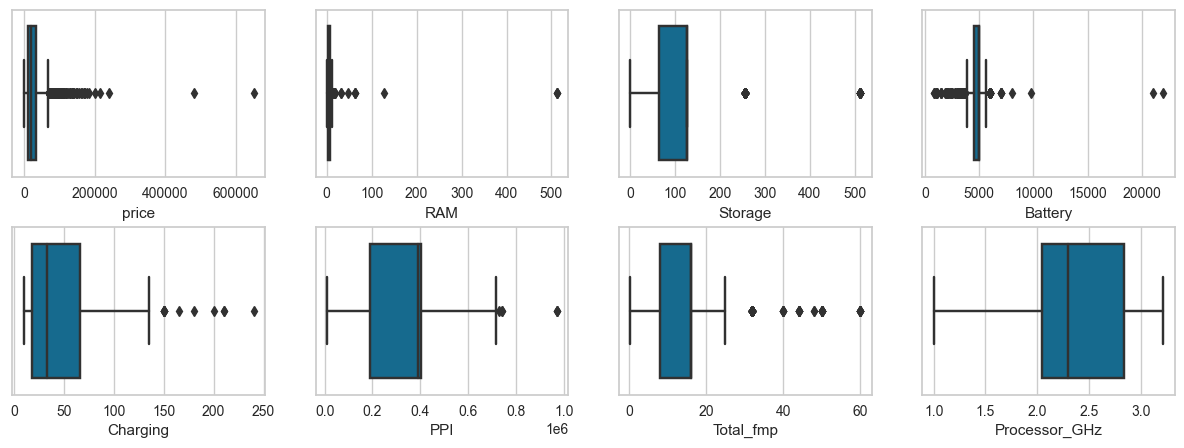

In [26]:
# Let's visualize outliers
fig,ax = plt.subplots(2,4,figsize = (15,5))

sns.boxplot(x = df['price'],ax = ax[0][0])
sns.boxplot(x = df['RAM'],ax = ax[0][1])
sns.boxplot(x = df['Storage'],ax = ax[0][2])
sns.boxplot(x = df['Battery'],ax = ax[0][3])

sns.boxplot(x = df['Charging'],ax = ax[1][0])
sns.boxplot(x = df['PPI'],ax = ax[1][1])
sns.boxplot(x = df['Total_fmp'],ax = ax[1][2])
sns.boxplot(x = df['Processor_GHz'],ax = ax[1][3])

plt.subplots_adjust(hspace = 0.3)
plt.show()

In [27]:
# Removing dummy phones and outliers from the features
df = df[(df['price']>4000) & (df['price']<400000)]
df =df[df['RAM']<20]

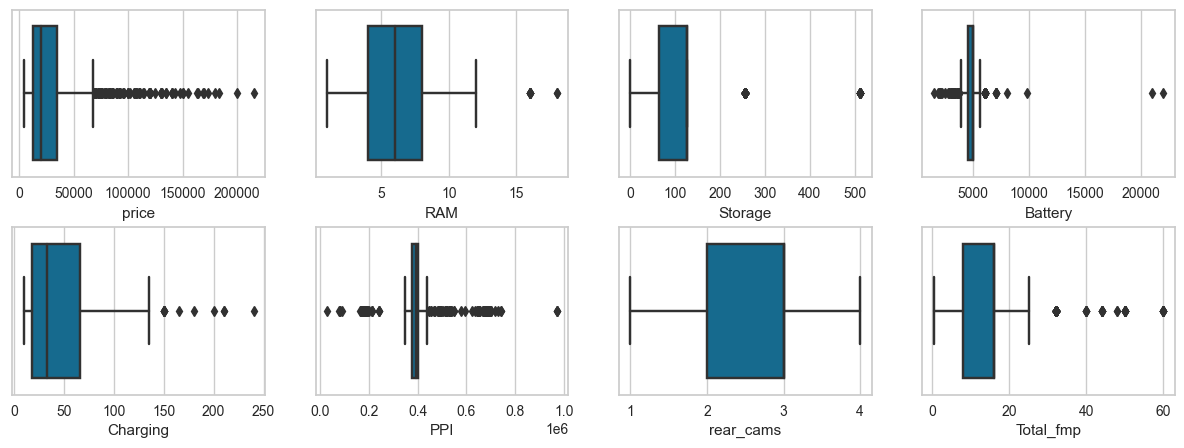

In [28]:
# Let's visualize outliers
fig,ax = plt.subplots(2,4,figsize = (15,5))

sns.boxplot(x = df['price'],ax = ax[0][0])
sns.boxplot(x = df['RAM'],ax = ax[0][1])
sns.boxplot(x = df['Storage'],ax = ax[0][2])
sns.boxplot(x = df['Battery'],ax = ax[0][3])

sns.boxplot(x = df['Charging'],ax = ax[1][0])
sns.boxplot(x = df['PPI'],ax = ax[1][1])
sns.boxplot(x = df['rear_cams'],ax = ax[1][2])
sns.boxplot(x = df['Total_fmp'],ax = ax[1][3])

plt.subplots_adjust(hspace = 0.3)
plt.show()

In [29]:
df.describe()

,price,Has_5g,Add_Features,RAM,Storage,Battery,Charging,Screen_RR,PPI,rear_cams,Total_fmp,Processor_GHz
count,972.000000,972.000000,972.000000,972.000000,972.000000,963.000000,767.000000,610.000000,963.000000,934.000000,934.000000,903.000000
mean,31271.416667,0.562757,0.058642,6.577160,136.367284,4824.997923,46.128683,111.624590,367859.631360,2.829764,16.642184,2.419258
std,30459.868938,0.496301,0.235074,2.731593,86.891162,1007.806318,34.306014,18.542944,135695.876024,0.769134,10.943134,0.474566
min,4499.000000,0.000000,0.000000,1.000000,1.000000,1450.000000,10.000000,90.000000,28444.000000,1.000000,0.300000,1.000000
25%,12999.000000,0.000000,0.000000,4.000000,64.000000,4500.000000,18.000000,90.000000,377194.000000,2.000000,8.000000,2.050000
50%,19990.000000,1.000000,0.000000,6.000000,128.000000,5000.000000,33.000000,120.000000,391540.000000,3.000000,16.000000,2.300000
75%,34999.000000,1.000000,0.000000,8.000000,128.000000,5000.000000,66.000000,120.000000,402484.000000,3.000000,16.000000,2.840000
max,214990.000000,1.000000,1.000000,18.000000,512.000000,22000.000000,240.000000,240.000000,971224.000000,4.000000,60.000000,3.220000


### Creating a copy of the training data

In [30]:
train_df,test_val_df = train_test_split(df,train_size = 0.8)
test_df,val_df = train_test_split(test_val_df,train_size = 0.5)

# Creating a copy of the training dataframe
temp_df = train_df.copy()

In [31]:
train_df.shape,test_df.shape,val_df.shape

((777, 17), (97, 17), (98, 17))

### Dealing with missing values

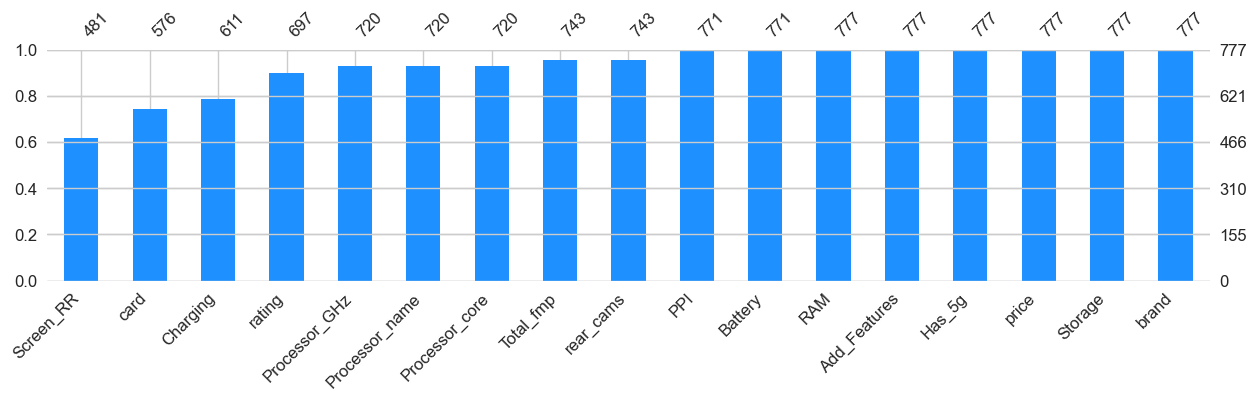

In [32]:
# Visualizing the missing values
msno.bar(temp_df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

From the above matrix it is visible that there are missing values but our selection of technqiue to deal with them will be based on the percentage of missing values.
- For features with less than 10% Missing values we will use simple univariate imputation techniques
- For features with more than 10% Missing values we will use the multi-variate imputation techniques

In [33]:
# let's get pecentage of missing values
print(temp_df.isnull().mean()*100)

brand              0.000000
price              0.000000
rating            10.296010
card              25.868726
Has_5g             0.000000
Add_Features       0.000000
RAM                0.000000
Storage            0.000000
Battery            0.772201
Charging          21.364221
Screen_RR         38.095238
PPI                0.772201
rear_cams          4.375804
Total_fmp          4.375804
Processor_name     7.335907
Processor_core     7.335907
Processor_GHz      7.335907
dtype: float64


In [34]:
# Let's get all teh features with 0 to 10% missing values
Less_10_Nan = [col for col in temp_df.columns if temp_df[col].isnull().mean()*100 > 0 and temp_df[col].isnull().mean()*100 < 10]
print(Less_10_Nan)

['Battery', 'PPI', 'rear_cams', 'Total_fmp', 'Processor_name', 'Processor_core', 'Processor_GHz']


All features having less than 10% Missing values are categorical in nature so we will be using the mode imputation.

In [35]:
# Mode imputation
for cols in Less_10_Nan:
    temp_df[cols].fillna(temp_df[cols].mode()[0],inplace=True)

For features having more than 10% Missing values we will be using the KNN imputer algorithm but before using this algorithm we need to encode the values in the card feature so we will do ordinal encoding of the card feature using the Ordinal encoder class

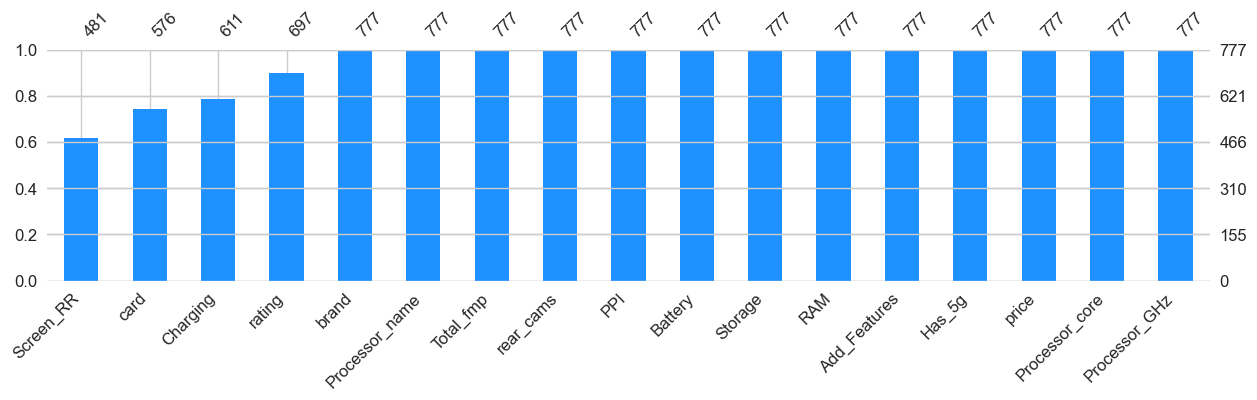

In [36]:
# Visualizing the missing values
msno.bar(temp_df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

In [37]:
cols = [
    'Memory Card Not Supported','Memory Card Supported, upto 16 GB','Memory Card Supported, upto 32 GB','Memory Card Supported, upto 48 GB',
    'Memory Card Supported, upto 64 GB','Memory Card Supported, upto 128 GB','Memory Card Supported, upto 256 GB',
    'Memory Card Supported, upto 512 GB','Memory Card Supported, upto 1 TB','Memory Card Supported, upto 2 TB','Memory Card (Hybrid)',
    'Memory Card (Hybrid), upto 64 GB','Memory Card (Hybrid), upto 128 GB','Memory Card (Hybrid), upto 256 GB',
    'Memory Card (Hybrid), upto 512 GB','Memory Card (Hybrid), upto 1 TB','Memory Card (Hybrid), upto 2 TB']

oe_card = OrdinalEncoder(categories=[cols],handle_unknown="use_encoded_value",unknown_value=np.nan)
temp_df['card'] = oe_card.fit_transform(temp_df['card'].values.reshape(-1,1)).reshape(-1)

oe_rating = OrdinalEncoder(categories=[['6+','7+','8+']],handle_unknown="use_encoded_value",unknown_value=np.nan)
temp_df['rating'] = oe_rating.fit_transform(temp_df['rating'].values.reshape(-1,1)).reshape(-1)

oe_proc_core = OrdinalEncoder(categories=[['Single','Dual','Quad','Hexa','Octa']],handle_unknown="use_encoded_value",unknown_value=np.nan)
temp_df['Processor_core'] = oe_proc_core.fit_transform(temp_df['Processor_core'].values.reshape(-1,1)).reshape(-1)

In [38]:
knn_imputer = KNNImputer(n_neighbors=5, metric="nan_euclidean")

cols = ["rating","Charging","card","Screen_RR"]
temp_df[cols] = knn_imputer.fit_transform(temp_df[cols])

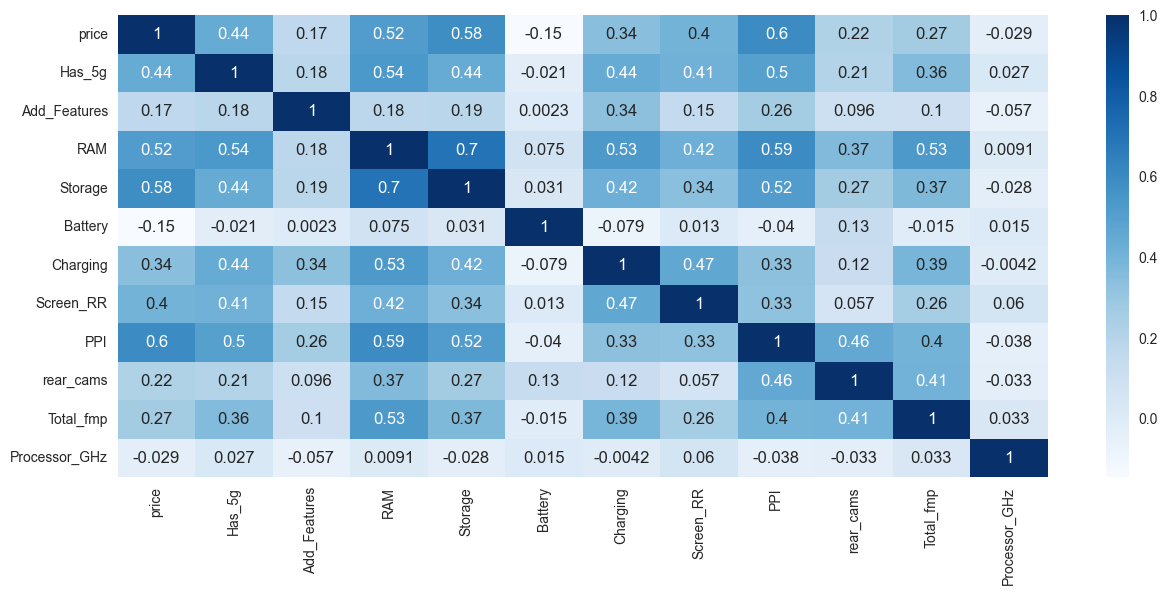

In [39]:
plt.figure(figsize=(15, 6))
sns.heatmap(df[['price', 'rating', 'card', 'Has_5g', 'Add_Features', 'RAM',
       'Storage', 'Battery', 'Charging', 'Screen_RR', 'PPI', 'rear_cams',
       'Total_fmp','Processor_core', 'Processor_GHz']].corr(), annot=True,cmap="Blues")
plt.show()

Since battery and Processor_Ghz are having very weak correlation with the target variable and the other variables so we will simply drop these features.

In [40]:
temp_df.drop(['Battery','Processor_GHz'],axis=1,inplace=True)

### Creation of pipeline to process the training data
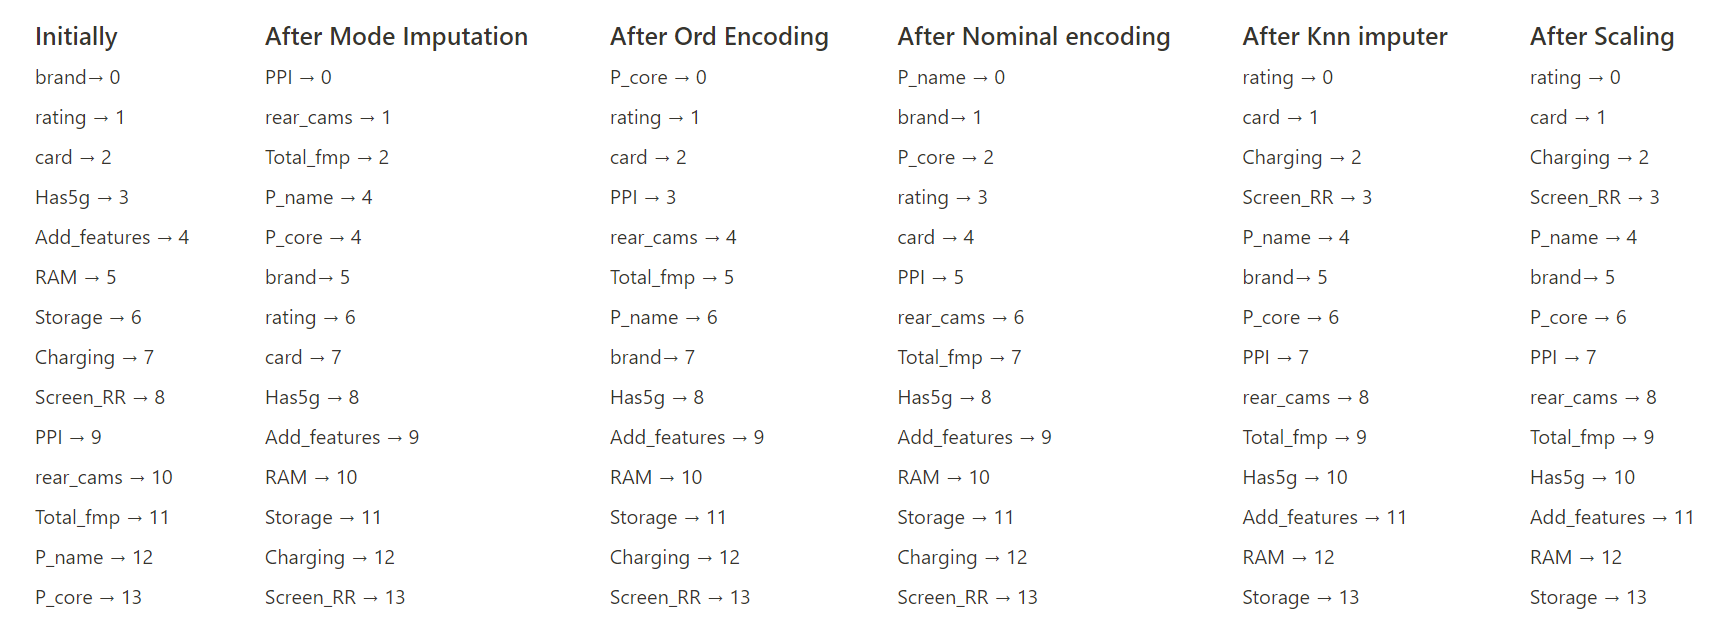

In [41]:
# Column transformer for univariate imputation (Mode)
Mode_impute = ColumnTransformer(transformers = [
    ('Mode_imputation',SimpleImputer(strategy='most_frequent'),[9,10,11,12,13])
],remainder='passthrough')

# Column transformer for the ordinal encoding
Oridnal_enc = ColumnTransformer(transformers = [
    ('OE_pcore',OrdinalEncoder(categories=[['Single','Dual','Quad','Hexa','Octa']],handle_unknown="use_encoded_value",unknown_value=np.nan),[4]),
    ('OE_rating',OrdinalEncoder(categories=[['6+','7+','8+']],handle_unknown="use_encoded_value",unknown_value=np.nan),[6]),
    ('OE_card',OrdinalEncoder(categories=[['Memory Card Not Supported','Memory Card Supported, upto 16 GB','Memory Card Supported, upto 32 GB',
                                                    'Memory Card Supported, upto 48 GB','Memory Card Supported, upto 64 GB',
                                                    'Memory Card Supported, upto 128 GB','Memory Card Supported, upto 256 GB',
                                                    'Memory Card Supported, upto 512 GB','Memory Card Supported, upto 1 TB',
                                                    'Memory Card Supported, upto 2 TB','Memory Card (Hybrid)','Memory Card (Hybrid), upto 64 GB',
                                                    'Memory Card (Hybrid), upto 128 GB','Memory Card (Hybrid), upto 256 GB',
                                                    'Memory Card (Hybrid), upto 512 GB','Memory Card (Hybrid), upto 1 TB',
                                                    'Memory Card (Hybrid), upto 2 TB']] ,handle_unknown="use_encoded_value",
                                                    unknown_value=np.nan),[7])],remainder='passthrough')

# Column transformer for nomnial encoding
Nom_enc = ColumnTransformer(transformers = [
    ('',ce.TargetEncoder(smoothing=0.2, handle_missing="return_nan", return_df=False),[6,7])
],remainder='passthrough')

# Column transformer for Knn imputer
Knn_imp =  ColumnTransformer(transformers = [
    ('Knn_imputer',KNNImputer(n_neighbors=5, metric="nan_euclidean"),[3,4,12,13])
],remainder='passthrough')

# Scaling the values
scaling = ColumnTransformer(transformers = [
    ('Stand_scaling',MinMaxScaler(),[0,1,2,3,4,5,6,7,8,9,10,11,12,13])
],remainder='passthrough')


# Building a pipeline
pipe = Pipeline(steps = [
    ('Mode_Imputation',Mode_impute),
    ('Ordinal_Encoding',Oridnal_enc),
    ('Nominal_Encoding',Nom_enc),
    ('KNN_Imputer',Knn_imp),
    ('Scaling',scaling)
])

In [42]:
train_df.drop(['Battery','Processor_GHz'],axis=1,inplace=True)
test_df.drop(['Battery','Processor_GHz'],axis=1,inplace=True)

In [52]:
# Seperating the dependent and independent variable
X_train = train_df.drop(['price'],axis = 1)
y_train = train_df['price']

X_test = test_df.drop(['price'],axis = 1)
y_test = test_df['price']

In [53]:
X_train = pipe.fit_transform(X_train,y_train)
X_test = pipe.transform(X_test)

# Pycaret

In [45]:
Input = df.drop(['price','Battery','Processor_GHz'],axis = 1)
Output = df['price']

Input = pipe.transform(Input)

In [46]:
pycaret_set = setup(data = Input,target = Output.values,train_size = 0.8,preprocess=False)

,Description,Value
0,Session id,583
1,Target,target
2,Target type,Regression
3,Original data shape,"(972, 15)"
4,Transformed data shape,"(972, 15)"
5,Transformed train set shape,"(777, 15)"
6,Transformed test set shape,"(195, 15)"
7,Numeric features,14


In [47]:
# All the models
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [55]:
# Let's get the best model
best_model = compare_models(fold=5, cross_validation=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,6538.3804,163287060.8724,12520.8550,0.8170,0.2755,0.2144,0.5520
gbr,Gradient Boosting Regressor,6884.9274,169277042.3041,12905.2370,0.8058,0.3037,0.2412,0.5060
et,Extra Trees Regressor,6798.9910,179387834.0177,13175.8438,0.7987,0.2927,0.2319,0.5420
lightgbm,Light Gradient Boosting Machine,7396.0947,213158872.1474,14396.7800,0.7591,0.3409,0.2448,0.4700
dt,Decision Tree Regressor,8090.8243,276463072.6949,16196.3878,0.6995,0.3540,0.2673,0.4180
knn,K Neighbors Regressor,9057.8343,295950350.5206,16955.0638,0.6639,0.3511,0.2705,0.4220
ridge,Ridge Regression,11440.0738,321558140.2350,17757.2863,0.6343,0.7087,0.4885,1.5960
br,Bayesian Ridge,11554.3730,321625893.0854,17765.4770,0.6337,0.6909,0.5003,0.4100
lasso,Lasso Regression,11628.3088,322172447.4029,17783.7794,0.6328,0.7393,0.5073,1.4560
llar,Lasso Least Angle Regression,11628.3097,322172396.4937,17783.7790,0.6328,0.7393,0.5073,0.4140


In [56]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Model training

In [54]:
model = RandomForestRegressor()

# Training the model with default hyper-parameters
model.fit(X_train,y_train)

# Getting predictions from model
y_pred = model.predict(X_test)

In [55]:
scores = cross_val_score(estimator = model, X = X_train, y = y_train, cv=50)
print("Average R2 Score",np.mean(scores))

Average R2 Score 0.8068917588203444


In [56]:
scores

array([0.91570995, 0.78541995, 0.96316909, 0.81364917, 0.5754316 ,
       0.56847457, 0.90869782, 0.93165801, 0.8662702 , 0.91866153,
       0.8848005 , 0.59831929, 0.96810312, 0.8852936 , 0.76331208,
       0.75527452, 0.61986346, 0.93616921, 0.92601901, 0.83013452,
       0.71739116, 0.86939355, 0.87252712, 0.58356288, 0.88143   ,
       0.8384533 , 0.96724472, 0.89884358, 0.78200427, 0.89236951,
       0.72446742, 0.54908769, 0.93060111, 0.78849266, 0.73967298,
       0.64255285, 0.93486544, 0.39244183, 0.74064445, 0.71118942,
       0.88523664, 0.94111917, 0.58034043, 0.7399788 , 0.96526846,
       0.69456475, 0.86520054, 0.94328351, 0.95824712, 0.89968142])

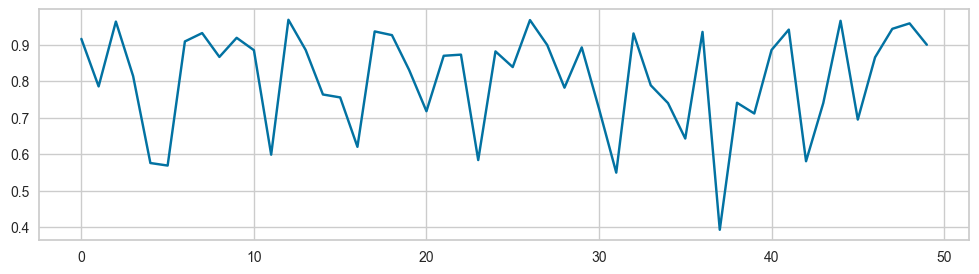

In [57]:
# Create a figure and axis
plt.figure(figsize=(12, 3))
plt.plot(scores)

In [60]:
# Save the model to a file using pickle
with open('Model.pkl', 'wb') as file:
    pickle.dump(model, file)